### Laboratório 8

Luiz Henrique da Silva Batista - Graduação - 12687228

#### 1. Bibliotecas e dependências

In [377]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plot
import random
import re
import nltk

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import CountVectorizer

from nltk import word_tokenize
from nltk.corpus import stopwords

In [378]:
random.seed(123456)

#### 2. Importação e pré-visualização

In [379]:
dados = pd.read_csv('../Dados/tweets_2.0_2020.csv')
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3002 entries, 0 to 3001
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   tweet_id              3002 non-null   object
 1   content               3002 non-null   object
 2   Corrected_sentimento  1407 non-null   object
 3   Corrected_stance      1407 non-null   object
 4   Corrected_relevante   3002 non-null   object
 5   Corrected_children    1408 non-null   object
 6   round                 3002 non-null   int64 
 7   date_post             3002 non-null   object
 8   year                  3002 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 211.2+ KB


#### 3. Análise Exploratória dos Dados (EDA)

##### Relevância

A Series abaixo apresenta distribuição das classes de relevância. Tweets relevantes são aqueles relacionados à vacinação contra a Covid-19.

In [380]:
relev = dados['Corrected_relevante'].value_counts(normalize=True).reset_index()
relev['perc'] = relev['proportion'] * 100
relev

,Corrected_relevante,proportion,perc
0,irrelevant,0.531312,53.131246
1,relevant,0.468688,46.868754


[Text(0, 0, '46.8688')]

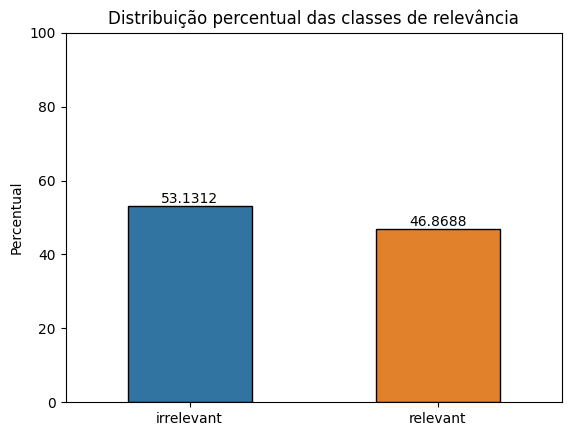

In [381]:
ax = sns.barplot(
    relev,
    x = 'Corrected_relevante', y = 'perc',
    hue = 'Corrected_relevante',
    width = 0.5,
    edgecolor = 'black')

# Edita
plot.ylim(0, 100)
plot.title('Distribuição percentual das classes de relevância')
plot.xlabel('')
plot.ylabel('Percentual')

# adiciona rotulos
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])

##### Posicionamento

A Series abaixo apresenta a frequência de ocorrência das classes de posicionamento. Os tweets são classificados como *favoráveis*, *desfavoráveis* e *unclear*.

In [382]:
# Filtra apenas os tweets relevantes (em tese, não precisa, mas vamos filtrar por precaução)
dados = dados[dados['Corrected_relevante'] == 'relevant']

stanc = dados['Corrected_stance'].value_counts(normalize=True).reset_index()
stanc['perc'] = stanc['proportion'] * 100
stanc

,Corrected_stance,proportion,perc
0,favorable,0.657427,65.742715
1,unclear,0.272210,27.221038
2,unfavorable,0.070362,7.036247


[Text(0, 0, '7.03625')]

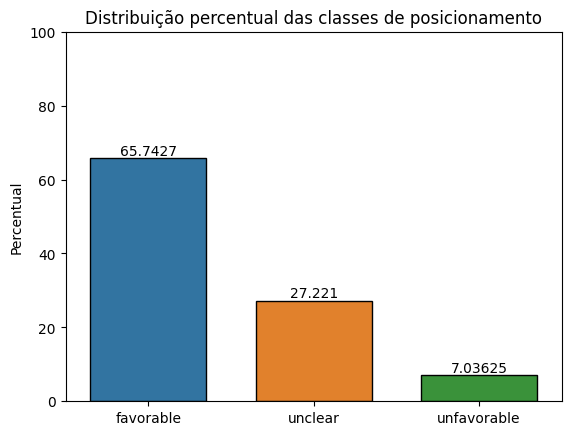

In [383]:
ax = sns.barplot(
    stanc,
    x = 'Corrected_stance', y = 'perc',
    hue = 'Corrected_stance',
    width = 0.7,
    edgecolor = 'black'
    )

# Edita
plot.ylim(0, 100)
plot.title('Distribuição percentual das classes de posicionamento')
plot.xlabel('')
plot.ylabel('Percentual')

# adiciona rotulos
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])

##### Análise da distribuição das classes

A distribuição da frequência de ocorrência das classes de posicionamento representa um risco para o ajuste do modelo, em virtude do desbalanceamento. Conforme a classe *favorable* possui mais dados do que as classes *unclear* e, principalmente, *unfavorable*, o modelo pode predizer mais a classe majoritária. Por outro lado, a distribuição das classes de relevância está mais equilibrada.

#### 5. Pré-processamento

##### Separação dos dados

In [384]:
features = dados['content']
target = dados['Corrected_stance']

##### Target: Label Encoding

In [385]:
label_encoding = {
    'favorable'   : 0,
    'unclear'     : 1,
    'unfavorable' : 2
}

target = target.map(label_encoding)
target.value_counts()

Corrected_stance
0    925
1    383
2     99
Name: count, dtype: int64

##### Features: Pré-processamento de texto

In [386]:
def preprocess_text(texto):
    # Converte tudo para minúsculo
    texto = texto.lower()
    # Remove URLs
    texto = re.sub(r'https://\S+', '', texto)
    # Remove quebra de linha
    texto = texto.replace('\\n', ' ')
    # Remove Hashtags
    texto = re.sub(r'#(\w+)', r'\1', texto)
    # Seleciona apenas as letras
    texto = re.findall(r'[a-zéóáêâãõç]+', texto)
    # Junta o texto, porque o .findall cria tokens
    texto = " ".join(texto)

    return texto

features = features.apply(preprocess_text)

##### Divisão entre treino e teste

In [387]:
x_treino, x_teste, y_treino, y_teste = train_test_split(
    features,
    target,
    test_size = 0.2,
    stratify = target,
    random_state = 123
)

In [388]:
print(f'Treino:\n\n{y_treino.value_counts(normalize=True)}')
print('\n')
print(f'Teste:\n\n{y_teste.value_counts(normalize=True)}')

Treino:

Corrected_stance
0    0.657778
1    0.272000
2    0.070222
Name: proportion, dtype: float64


Teste:

Corrected_stance
0    0.656028
1    0.273050
2    0.070922
Name: proportion, dtype: float64


##### Vetorização com Bag of Words

In [389]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Luiz
[nltk_data]     Henrique/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [390]:
# Lista das stop words do português
stop_words = stopwords.words('portuguese')

# Vetorizador: converte um conjunto de textos em uma matriz de contagem de palavras
vectorizer = CountVectorizer(stop_words=stop_words, ngram_range=(1,1))

Features de Treino

In [391]:
# Aplicando o BoW base de treino
x_treino = vectorizer.fit_transform(x_treino)

# Transforma o x em um data frame
x_treino_bow = pd.DataFrame(x_treino.toarray())

Features de teste

In [392]:
# Aplicando o BoW na base de teste
x_teste = vectorizer.transform(x_teste)

# Transforma o x em um data frame
x_teste_bow = pd.DataFrame(x_teste.toarray())

#### 6. Ajuste do modelo multinomial

Abaixo, ajustamos um modelo multinomial, padronizando os hiper

In [393]:
# Regressão Logística
modelo = LogisticRegression()

# Ajuste do modelo
modelo.fit(x_treino_bow, y_treino)

# Predições
y_pred = modelo.predict(x_teste_bow)

#### 7. Avaliação

##### Matriz de Confusão

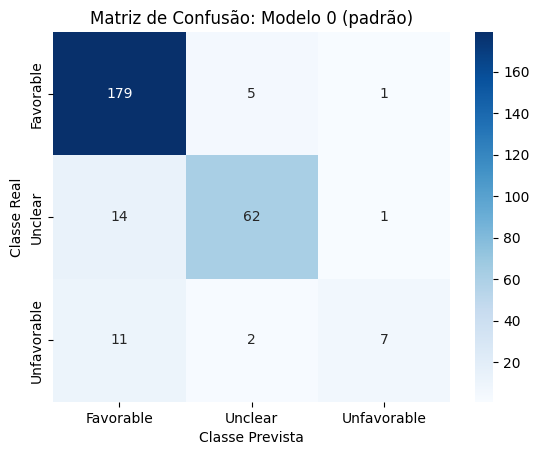

In [394]:
matriz_conf = confusion_matrix(y_teste, y_pred)

# Definação os rótulos das classes
class_names = ['Favorable', 'Unclear', 'Unfavorable']

# Gráfico da matriz de confusão
sns.heatmap(matriz_conf, # Nossa matriz gerada pelo sklearn
            annot=True,
            fmt='d', # Dígitos completos
            cmap='Blues', # Cor da matriz
            xticklabels=class_names,
            yticklabels=class_names)
plot.xlabel('Classe Prevista')
plot.ylabel('Classe Real')
plot.title('Matriz de Confusão: Modelo 0 (padrão)')
plot.show()

##### Relatório

In [395]:
print(classification_report(y_teste, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       185
           1       0.90      0.81      0.85        77
           2       0.78      0.35      0.48        20

    accuracy                           0.88       282
   macro avg       0.85      0.71      0.75       282
weighted avg       0.88      0.88      0.87       282



##### Conclusões

O modelo apresenta sérios problemas na classificação da classe minoritária (2: unfavorable). Com um recall de 0.35, podemos perceber que o modelo tem dificuldades de identificar corretamente a maioria dos tweets unfavorable.

#### 8. K-Fold e Tuning

##### Modelo 0 (default)

##### Train Test Split

In [396]:
# Seperação entre treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(
    features,
    target,
    test_size = 0.2,
    stratify = target,
    random_state = 123
)

##### KFold

In [397]:
# Definição do número de K
kf = KFold(n_splits=10)

In [398]:
# Definição dos folds
for i, (train_index, test_index) in enumerate(kf.split(x_treino)):
  print(f"Dobra (Fold) {i}:")
  print(f"  Treino: tamanho={len(train_index)}")
  print(f"  Teste:  tamanho={len(test_index)}")

Dobra (Fold) 0:
  Treino: tamanho=1012
  Teste:  tamanho=113
Dobra (Fold) 1:
  Treino: tamanho=1012
  Teste:  tamanho=113
Dobra (Fold) 2:
  Treino: tamanho=1012
  Teste:  tamanho=113
Dobra (Fold) 3:
  Treino: tamanho=1012
  Teste:  tamanho=113
Dobra (Fold) 4:
  Treino: tamanho=1012
  Teste:  tamanho=113
Dobra (Fold) 5:
  Treino: tamanho=1013
  Teste:  tamanho=112
Dobra (Fold) 6:
  Treino: tamanho=1013
  Teste:  tamanho=112
Dobra (Fold) 7:
  Treino: tamanho=1013
  Teste:  tamanho=112
Dobra (Fold) 8:
  Treino: tamanho=1013
  Teste:  tamanho=112
Dobra (Fold) 9:
  Treino: tamanho=1013
  Teste:  tamanho=112


In [399]:
# Aplicando o BoW base de treino em que foi feito o KFold
x_treino_bow_kf = vectorizer.fit_transform(x_treino)

In [400]:
# Ajuste dos inputs
y_treino_array = y_treino.to_numpy()

In [401]:
# Cria um dataframe vazio para armazenar as métricas
resultados1 = pd.DataFrame()

In [ ]:
# Loop de treinamento
for i, (train_index, test_index) in enumerate(kf.split(x_treino_bow_kf)):

  # Divisão dos dados entre treino e teste
  x_treino_kf, x_teste_kf = x_treino_bow_kf[train_index, :], x_treino_bow_kf[test_index, :]
  y_treino_kf, y_teste_kf = y_treino_array[train_index], y_treino_array[test_index]

  # Treinando o modelo
  modelo = LogisticRegression()
  modelo.fit(x_treino_kf, y_treino_kf)

  # Avaliação do modelo
  y_pred_kf = modelo.predict(x_teste_kf)

  # Armazenando as métricas
  metricas_kf = precision_recall_fscore_support(
      y_teste_kf, y_pred_kf,
      average = None,
      labels = [0, 1, 2],
      zero_division = True
  )

  # Desempacota os valores
  precision, recall, f1, suporte = metricas_kf

  # Criando um dicionario com os resultados
  metricas_dict = {
      'precision':precision,
      'recall':recall,
      'f1':f1,
      'suporte':suporte,
      'fold':i
  }

  # Cria um dataframe com esse dicionário
  metricas_df = pd.DataFrame(metricas_dict)

  # Converte o index em uma cooluna
  metricas_df.reset_index(inplace=True)

  # Renomeia essa coluna
  metricas_df = metricas_df.rename(columns = {'index':'classe'})

 # Colocando os resultados dentre do df criado fora do loop
resultados1 = pd.concat([metricas_df, resultados1], axis = 0)

In [403]:
# Reseta o index
resultados1 = resultados1.reset_index(drop = True)

##### Avaliação

In [404]:
renomeia_classes = {
    0:'favorable',
    1:'unclear',
    2:'unfavorable'
}

resultados1['classe'] = resultados1['classe'].map(renomeia_classes)
resultados1.head()

,classe,precision,recall,f1,suporte,fold
0,favorable,0.865854,0.986111,0.922078,72,9
1,unclear,0.964286,0.794118,0.870968,34,9
2,unfavorable,1.000000,0.333333,0.500000,6,9
3,favorable,0.809524,0.957746,0.877419,71,8
4,unclear,0.727273,0.640000,0.680851,25,8


Precision

(-0.1, 1.1)

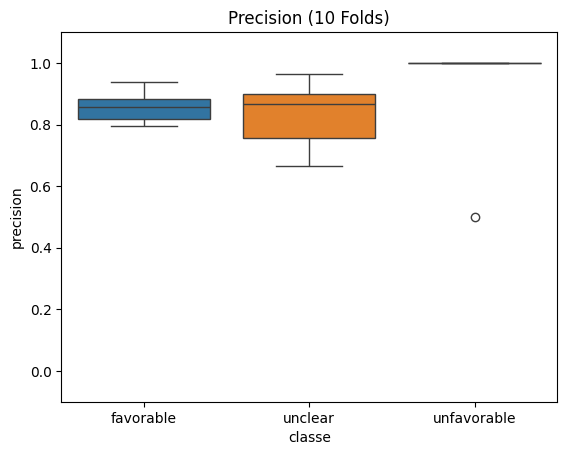

In [405]:
sns.boxplot(resultados1, x = 'classe', y = 'precision', hue='classe')

plot.title("Precision (10 Folds)")
plot.ylim(-0.1, 1.1)

Recall

(0.0, 1.0)

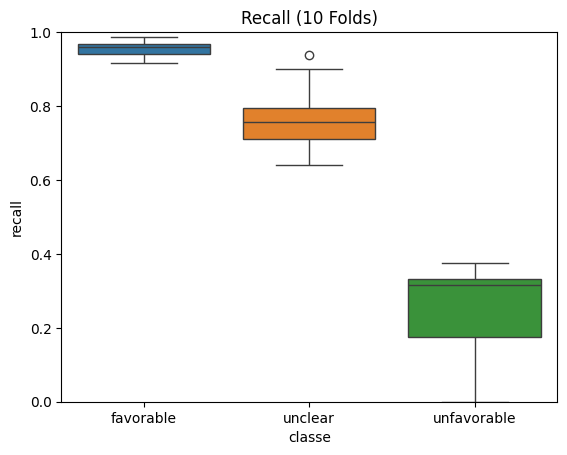

In [406]:
sns.boxplot(resultados1, x = 'classe', y = 'recall', hue='classe')

plot.title("Recall (10 Folds)")
plot.ylim(0, 1)

F1-Score

(0.0, 1.0)

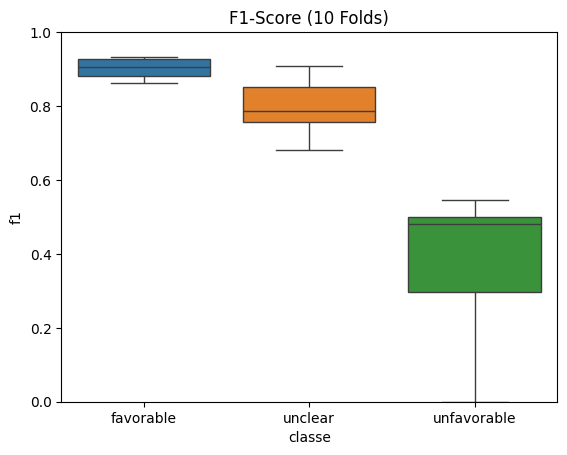

In [407]:
sns.boxplot(resultados1, x = 'classe', y = 'f1', hue='classe')

plot.title("F1-Score (10 Folds)")
plot.ylim(0, 1)

Os resultados acima indicam que o modelo tem um desempenho melhor na classificação das classes "favorável" e "unclear". No entanto, em relação à classe "unfavorable", que é a classe minoritária, o modelo demonstra dificuldade. O F1-score, que é a média harmônica entre precisão e recall, mostra que a rotulação da classe majoritária "favorável" apresenta um F1-score superior a 0,8. A classe "unclear" apresenta um F1-score em torno de 0,8, enquanto a classe "unfavorable" fica em varia de 0 a quase 0,6.

#### 9. Mudança nos hiperparâmetros

Aqui está o texto revisado e uma tabela em Markdown com as configurações dos três modelos:

Vamos realizar um experimento comparando o modelo padrão com outros dois modelos. O modelo padrão é aquele cujos hiperparâmetros não foram alterados, ou seja, usamos as configurações padrão. Nos outros dois modelos, ajustamos os hiperparâmetros para observar diferenças de desempenho, embora ambos sejam essencialmente iguais, exceto pela regularização:

| Modelo   | Penalty | C   | Solver | Max Iter |
|----------|---------|-----|--------|----------|
| Padrão   | l2  | 1.0 | lbfgs | 100  |
| Modelo 1 | l1      | 1.0 | saga   | 500      |
| Modelo 2 | l2      | 1.0 | saga   | 500      |

- **Modelo 1**: Regularização `l1`, com `C=1.0`, `solver='saga'`, e `max_iter=500`.
- **Modelo 2**: Regularização `l2`, com `C=1.0`, `solver='saga'`, e `max_iter=500`.

Essas configurações permitem testar o efeito de diferentes tipos de regularização (`l1` e `l2`) no desempenho do modelo.

##### Modelo 1

In [408]:
# Cria um dataframe vazio para armazenar as métricas
resultados2 = pd.DataFrame()

In [409]:
# Loop de treinamento
for i, (train_index, test_index) in enumerate(kf.split(x_treino_bow_kf)):

  # Divisão dos dados entre treino e teste
  x_treino_kf, x_teste_kf = x_treino_bow_kf[train_index, :], x_treino_bow_kf[test_index, :]
  y_treino_kf, y_teste_kf = y_treino_array[train_index], y_treino_array[test_index]

  # Treinando o modelo
  modelo = LogisticRegression(
      penalty = 'l1', 
      C = 1.0,
      solver = 'saga',
      max_iter = 500,
      random_state=123)
  modelo.fit(x_treino_kf, y_treino_kf)

  # Avaliação do modelo
  y_pred_kf = modelo.predict(x_teste_kf)

  # Armazenando as métricas
  metricas_kf = precision_recall_fscore_support(
      y_teste_kf, y_pred_kf,
      average = None,
      labels = [0, 1, 2],
      zero_division = True
  )

  # Desempacota os valores
  precision, recall, f1, suporte = metricas_kf

  # Criando um dicionario com os resultados
  metricas_dict = {
      'precision':precision,
      'recall':recall,
      'f1':f1,
      'suporte':suporte,
      'fold':i
  }

  # Cria um dataframe com esse dicionário
  metricas_df = pd.DataFrame(metricas_dict)

  # Converte o index em uma cooluna
  metricas_df.reset_index(inplace=True)

  # Renomeia essa coluna
  metricas_df = metricas_df.rename(columns = {'index':'classe'})

  # Colocando os resultados dentre do df criado fora do loop
  resultados2 = pd.concat([metricas_df, resultados2], axis = 0)

c:\Users\Luiz Henrique\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Luiz Henrique\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Luiz Henrique\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Luiz Henrique\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Luiz Henrique\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: T

In [410]:
renomeia_classes = {
    0:'favorable',
    1:'unclear',
    2:'unfavorable'
}

resultados2['classe'] = resultados2['classe'].map(renomeia_classes)
resultados2.head()

,classe,precision,recall,f1,suporte,fold
0,favorable,0.864198,0.972222,0.915033,72,9
1,unclear,0.931034,0.794118,0.857143,34,9
2,unfavorable,1.000000,0.333333,0.500000,6,9
0,favorable,0.811765,0.971831,0.884615,71,8
1,unclear,0.772727,0.680000,0.723404,25,8


##### Modelo 2

In [411]:
# Cria um dataframe vazio para armazenar as métricas
resultados3 = pd.DataFrame()

In [412]:
# Loop de treinamento
for i, (train_index, test_index) in enumerate(kf.split(x_treino_bow_kf)):

  # Divisão dos dados entre treino e teste
  x_treino_kf, x_teste_kf = x_treino_bow_kf[train_index, :], x_treino_bow_kf[test_index, :]
  y_treino_kf, y_teste_kf = y_treino_array[train_index], y_treino_array[test_index]

  # Treinando o modelo
  modelo = LogisticRegression(
      penalty = 'l2', 
      C = 1.0,
      solver = 'saga',
      max_iter = 500,
      random_state=123)
  modelo.fit(x_treino_kf, y_treino_kf)

  # Avaliação do modelo
  y_pred_kf = modelo.predict(x_teste_kf)

  # Armazenando as métricas
  metricas_kf = precision_recall_fscore_support(
      y_teste_kf, y_pred_kf,
      average = None,
      labels = [0, 1, 2],
      zero_division = True
  )

  # Desempacota os valores
  precision, recall, f1, suporte = metricas_kf

  # Criando um dicionario com os resultados
  metricas_dict = {
      'precision':precision,
      'recall':recall,
      'f1':f1,
      'suporte':suporte,
      'fold':i
  }

  # Cria um dataframe com esse dicionário
  metricas_df = pd.DataFrame(metricas_dict)

  # Converte o index em uma cooluna
  metricas_df.reset_index(inplace=True)

  # Renomeia essa coluna
  metricas_df = metricas_df.rename(columns = {'index':'classe'})

  # Colocando os resultados dentre do df criado fora do loop
  resultados3 = pd.concat([metricas_df, resultados3], axis = 0)

c:\Users\Luiz Henrique\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Luiz Henrique\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Luiz Henrique\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Luiz Henrique\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Luiz Henrique\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: T

In [413]:
renomeia_classes = {
    0:'favorable',
    1:'unclear',
    2:'unfavorable'
}

resultados3['classe'] = resultados3['classe'].map(renomeia_classes)
resultados3.head()

,classe,precision,recall,f1,suporte,fold
0,favorable,0.865854,0.986111,0.922078,72,9
1,unclear,0.964286,0.794118,0.870968,34,9
2,unfavorable,1.000000,0.333333,0.500000,6,9
0,favorable,0.809524,0.957746,0.877419,71,8
1,unclear,0.727273,0.640000,0.680851,25,8


##### Avaliação comparativa

In [414]:
# Cria coluna para identificar o método de regularização
resultados1['modelo'] = 'Default'
resultados2['modelo'] = 'Penalty = L1'
resultados3['modelo'] = 'Penalty = L2'

# Junta resultados1 e resultados2
resultados = pd.concat([resultados1, resultados2, resultados3], axis = 0)

resultados.head()

,classe,precision,recall,f1,suporte,fold,modelo
0,favorable,0.865854,0.986111,0.922078,72,9,Default
1,unclear,0.964286,0.794118,0.870968,34,9,Default
2,unfavorable,1.000000,0.333333,0.500000,6,9,Default
3,favorable,0.809524,0.957746,0.877419,71,8,Default
4,unclear,0.727273,0.640000,0.680851,25,8,Default


Precision

(-0.1, 1.1)

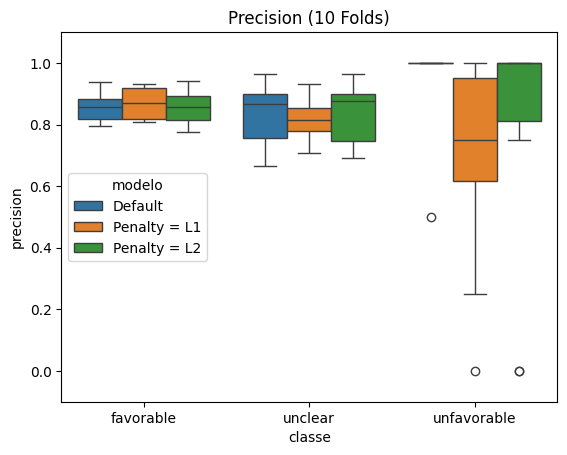

In [415]:
sns.boxplot(resultados, x = 'classe', y = 'precision', hue='modelo')

plot.title("Precision (10 Folds)")
plot.ylim(-0.1, 1.1)

Recall

(-0.1, 1.1)

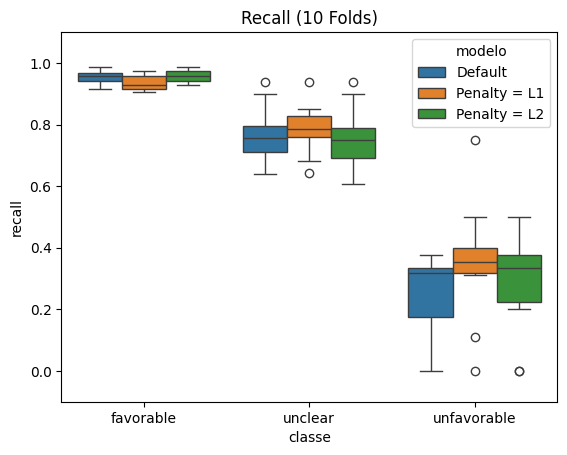

In [417]:
sns.boxplot(resultados, x = 'classe', y = 'recall', hue='modelo')

plot.title("Recall (10 Folds)")
plot.ylim(-0.1, 1.1)

F1-Score

(-0.1, 1.1)

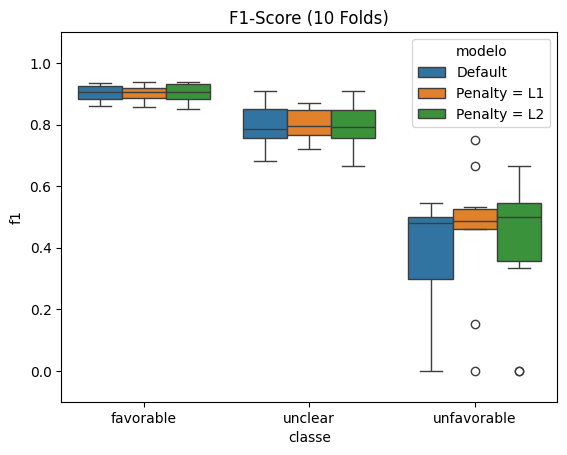

In [421]:
sns.boxplot(resultados, x = 'classe', y = 'f1', hue='modelo')

plot.title("F1-Score (10 Folds)")
plot.ylim(-0.1, 1.1)